In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from scipy.spatial import distance_matrix
import warnings
warnings.filterwarnings("ignore")

# Data processing

In [2]:
# load dataset
data = scipy.io.loadmat('spamData.mat')
Xtrain, Xtest, ytrain, ytest = data["Xtrain"], data["Xtest"], data["ytrain"], data["ytest"]
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

# log transform
Xtrain_log, Xtest_log = np.log(Xtrain+0.1), np.log(Xtest+0.1)

# binarize
Xtrain_bin = Xtrain.copy()
Xtrain_bin[Xtrain <= 0] = 0
Xtrain_bin[Xtrain > 0] = 1

Xtest_bin = Xtest.copy()
Xtest_bin[Xtest <= 0] = 0
Xtest_bin[Xtest > 0] = 1

# print class distribution
print("training set: {:.2f}% of SPAM, testing set: {:.2f}% of SPAM".format(100*len(ytrain[ytrain==1])/len(ytrain), 100*len(ytest[ytest==1])/len(ytest)))

(3065, 57) (1536, 57) (3065, 1) (1536, 1)
training set: 38.83% of SPAM, testing set: 40.56% of SPAM


The training and testing set classes are balanced as the proportion of SPAM is similar.

# Q1 Beta-binomial Naive Bayes


In [3]:
class betabinomial_NB:

    def __init__(self, alpha=2, head=1):
        """
        class for beta-binomial Naive Bayes classifer
        binary classifier
        ...
        Parameters
        ----------
        alpha: int
            parameter of the Beta distribution
        head: int, value 0 or 1
            convention defining the head class
        """
        self.alpha = alpha
        self.head = head
        self.class_prior = None  # initialisation
        self.feature_likelihood = None  # intialisation
        
    def fit(self, Xtrain, ytrain):
        """ 
        Parameters
        ----------
        Xtrain: numpy nd matrix of 0 or 1 (type float), dim N*D, N=number of samples, D=number of features
            dataset used to train the model 
        ytrain: numpy nd matrix of 0 or 1 (type float), dim N*1, N=number of samples
            label class of each training sample
        Returns
        -------
        class_prior: float,
            ML estimate of class prior, equal to frequency of head class
        feature_likelihood: array of dim D*1 of floats,
            posterior predictive with prior Beta(alpha, alpha) for binary feature likelihood
        """
        # compute class prior from training set
        self.class_prior = len(ytrain[ytrain == self.head])/ len(ytrain) # ML estimate, frequency of head class
        # compute feature likelihood from training set
        N1 = np.zeros((Xtrain.shape[1], 2))
        for c in [0, 1]:  # for each class
            N = len(ytrain[ytrain == c]) # number of training samples in this class
            N1[:,c] = np.sum(Xtrain[np.squeeze(ytrain == c),:], axis=0)
            # for each feature, number of times the feature is equal to the head class among class c
            self.feature_likelihood = np.array([np.log((n1 + self.alpha / N + 2*self.alpha)) for n1 in N1])
            # posterior predictive with prior Beta(alpha, alpha) 
        return self.class_prior, self.feature_likelihood # class prior and binary feature likelihood

    def predict(self, Xtest):
        """
        Parameters
        ----------
        Xtest: numpy nd matrix of 0 or 1 (type float), dim n*D, n=number of samples, D=number of features
            dataset with labels to predict
        Returns
        -------
        ypred: numpy nd matrix of 0 or 1 (type float), dim n*1, n=number of samples
            predicted labels for each test sample
        """
        logpreds = np.empty((Xtest.shape[0], 2)) # initialise log prob prediction for each class
        ypred = np.empty((Xtest.shape[0],1)) # initialise label prediction
        for c in [0, 1]:  # for each class c
            log_class_prior = np.array([np.log(self.class_prior) if c is self.head else np.log(1-self.class_prior) for _ in range(Xtest.shape[0])])
            feature_likelihood = np.tile(self.feature_likelihood[:,c],(Xtest.shape[0], 1))
            log_feature_likelihood = np.sum(np.where(Xtest == 1, feature_likelihood, 1-feature_likelihood), axis=1)
            # for each feature, sum the logs of features likelihood which formula depends on feature value
            # feature are assumed conditionnaly independent, so likelihood is the product of probs for each feature
            # and the log properties gives that the product of probs corresponds to the sum of log probs 
            log_prob_class = log_class_prior + log_feature_likelihood
            # probability of the sample belonging to class c is the sum of class prior and feature likelihood probabilities
            # and logarithm properties allow to transform the product into a sum
            logpreds[:, c] = log_prob_class # store log prob for each test sample of belonging to class c
        ypred = np.expand_dims(np.argmax(logpreds, axis=1), axis=1) # label prediction is the class with the highest log prob
        return ypred
        

he training and testing error are quite close to each other. Both errors decreased when the alpha parameter increases. There is also a drop in the error at around alpha=80.


,train,test
1,0.517129,0.511068
10,0.465253,0.469401
100,0.279935,0.287109


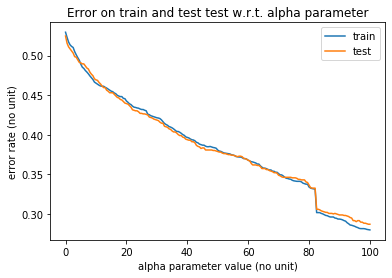

In [4]:
# training and testing errors

alpha_list = [i/2 for i in range(201)]  # list of alpha parameters to consider for the beta distribution 

error_dict = {}  # initialise dictionary to gather error results
for alpha in alpha_list:
    model = betabinomial_NB(alpha, head=1) # define model, head class = SPAM (1), tail class = nonSPAM (0)
    model.fit(Xtrain_bin, ytrain) # fit model on training dataset
    ypred_train_alpha = model.predict(Xtrain_bin) # predict labels on training set
    ypred_test_alpha = model.predict(Xtest_bin) # predict labels on testing set
    error_train_alpha = len(ypred_train_alpha[ypred_train_alpha != ytrain]) / len(ytrain) # compute training error
    error_test_alpha = len(ypred_test_alpha[ypred_test_alpha != ytest]) / len(ytest)  # compute testing error
    error_dict[alpha] = [error_train_alpha, error_test_alpha]
error_df = pd.DataFrame.from_dict(error_dict).T
error_df.columns = ["train", "test"]

# ploting train and test errors w.r.t alpha
error_df.plot()
plt.xlabel("alpha parameter value (no unit)")
plt.ylabel("error rate (no unit)")
plt.title("Error on train and test test w.r.t. alpha parameter")
# comments on the graph obtained
print("he training and testing error are quite close to each other."
      " Both errors decreased when the alpha parameter increases."
      " There is also a drop in the error at around alpha=80.")
# print errors in train and test set at alpha = 1, 10, 100
error_df.loc[[1, 10, 100]]

# Q2 Gaussian Naive-Bayes

In [5]:
def gaussian(x, mu, sigma):
    """
    gaussian function with parameters mu (float) and sigma (float, >0) estimates at value x (float)
    """
    return (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))


class gaussian_NB:
    
    def __init__(self, head=1):
        """
        class for gaussian Naive Bayes classifer
        binary classifier
        ...
        Parameters
        ----------
        head: int, value 0 or 1
            convention defining the head class
        """
        self.head = head
        self.class_prior = None
        self.feature_likelihood = None
        
    def fit(self, Xtrain, ytrain):
        """
        Parameters
        ----------
        Xtrain: numpy nd matrix of 0 or 1 (type float), dim N*D, N=number of samples, D=number of features
            dataset used to train the model 
        ytrain: numpy nd matrix of 0 or 1 (type float), dim N*1, N=number of samples
            label class of each training sample
        Returns
        -------
        class_prior: float,
            ML estimate of class prior, equal to frequency of head class
        feature_likelihood: list of 2 arrays of dim D*1 of floats,
            ML estimation of mu and sigma for each feature
        """
        # compute class prior from training set
        self.class_prior = len(ytrain[ytrain == self.head])/ len(ytrain) # ML estimate, frequency of head class
        # compute feature likelihood from training set
        mean_feat, std_feat = np.zeros((Xtrain.shape[1], 2)), np.zeros((Xtrain.shape[1], 2))  # initialise
        for c in [0, 1]: # for each class
            mean_feat[:,c] = np.mean(Xtrain[np.squeeze(ytrain == c),:], axis=0) # ML estimation of mu for each feature
            std_feat[:,c] = np.std(Xtrain[np.squeeze(ytrain == c),:], axis=0)  # ML estimation of sigma for each feature
        self.feature_likelihood = [mean_feat, std_feat]
        return self.class_prior, self.feature_likelihood

    def predict(self, Xtest):
        """
        Parameters
        ----------
        Xtest: numpy nd matrix of 0 or 1 (type float), dim n*D, n=number of samples, D=number of features
            dataset with labels to predict
        Returns
        -------
        ypred: numpy nd matrix of 0 or 1 (type float), dim n*1, n=number of samples
            predicted labels for each test sample
        """
        logpreds = np.empty((Xtest.shape[0], 2)) # initialise log prob prediction for each class
        ypred = np.empty((Xtest.shape[0],1)) # initialise label prediction
        mean_feat, std_feat = self.feature_likelihood
        for c in [0, 1]: # for each class
            log_class_prior = np.array([np.log(self.class_prior) if c is self.head else np.log(1-self.class_prior) for _ in range(Xtest.shape[0])])
            log_feature_likelihood = np.sum(np.log(gaussian(Xtest, mean_feat[:,c], std_feat[:,c])), axis=1)
            log_prob_class = log_class_prior + log_feature_likelihood
            # for each feature, sum the logs of features likelihood which formula depends on feature value
            # feature are assumed conditionnaly independent, so likelihood is the product of probs for each feature
            # and the log properties gives that the product of probs corresponds to the sum of log probs 
            log_prob_class = log_class_prior + log_feature_likelihood
            # probability of the sample belonging to class c is the sum of class prior and feature likelihood probabilities
            # and logarithm properties allow to transform the product into a sum
            logpreds[:, c] = log_prob_class # store log prob for each test sample of belonging to class c
        ypred = np.expand_dims(np.argmax(logpreds, axis=1), axis=1)
        return(ypred)

In [6]:
model = gaussian_NB()
model.fit(Xtrain_log, ytrain)
ypred_train_gaussian = model.predict(Xtrain_log)
ypred_test_gaussian = model.predict(Xtest_log)
error_train_gaussian = len(ypred_train_gaussian[ypred_train_gaussian != ytrain]) / len(ytrain)
error_test_gaussian = len(ypred_test_gaussian[ypred_test_gaussian != ytest]) / len(ytest)
print("error on training set: {:.2f}%, error on test set: {:.2f}%".format(error_train_gaussian*100, error_test_gaussian*100))

error on training set: 16.67%, error on test set: 18.36%


# Q3 Logistic Regression

In [7]:
def sigmoid(X, w):
    """sigmoid function applied to a dataset X (2D numpy array) with weigths array w"""
    mu = np.expand_dims(np.array([1/(1+np.exp(-np.dot(np.transpose(w), X[i,:])))[0] for i in range(X.shape[0])]), axis=1)
    return mu

def log_likelihood(X, y, w):
    """log likelihood applied to a dataset X (2D numpy array) with weigths array w and labels array y"""
    mu = sigmoid(X, w)
    return -(np.dot(np.transpose(y), np.log(mu))[0][0] + np.dot(np.transpose(1-y), np.log(1-mu))[0][0])

def newton_method_optimizer(X, y, theta0, g, args_g, H, args_H, step=1, epsilon=10e-3, max_iter = 15):
    """
    Parameters
    ----------
    X: numpy nd matrix of floats, dim n*D, n=number of samples, D=number of features
        dataset with labels to predict
    y: numpy nd matrix of 0 or 1 (type float), dim n*1, n=number of samples
        predicted labels for each test sample
    theta0: numpy nd matrix of floats, dim D*1, n=number of features
        initalised parameter vector to learn using the training dataset X,y
    g: function,
        returns the gradient
    args_g: dictionary
        dictionary of the parameters to pass to the g function
    H: function,
        returns the Hessian
    args_g: dictionary
        dictionary of the parameters to pass to the H function
    step: float (default=1)
        step length to update the parameter theta 
    epsilon: float (default=10e-5)
        convergence criteria, set to stop learning the parameter theta
        when the difference in likelihood with last iteration is no more than epsilon 
    max_iter: int (default=15)
        maximum number of iterations to learn parameter theta
    Returns
    -------
    theta: numpy nd matrix of floats, dim D*1, n=number of features
        the learned vector parameter
    """
    theta = theta0 # initialise parameter
    lk = log_likelihood(X, y, theta0) # compute initial log likelihood
    k = 0 # counter of iterations
    cond = True # initialise condition of non convergence
    while cond: # while condition of convergence is not reached, process to iteration k+1
        gk = g(**args_g, w=theta) # compute the gradient
        Hk = H(**args_H, w=theta) # compute the Hessian
        if Hk.shape[0] == Hk.shape[1] and np.linalg.matrix_rank(Hk) == Hk.shape[0]: # check if Hk non singular
            theta = theta - step*np.matmul(np.linalg.inv(Hk),gk) # update theta
            lk_new = log_likelihood(X, y, theta) # compute new log likelihood
            delta = abs(lk_new - lk) # compute difference delta between new and former theta log likelihood
            cond = delta > epsilon and k < max_iter  # while convergence criteria or max iterations
        else: # if Hk singular
            cond = False # stop iterating and break the loop
        k += 1 # update counter
    return theta

def g_logisticregression_reg(X, y, l, w):
    """
    Parameters
    ----------
    X: numpy nd matrix of floats, dim n*D, n=number of samples, D=number of features
        dataset with labels to predict
    y: numpy nd matrix of 0 or 1 (type float), dim n*1, n=number of samples
        predicted labels for each test sample
    l: float
        regularisation parameter
    w: numpy nd matrix of floats, dim D*1, n=number of features
        parameter vector
    Returns
    -------
    gradient t(X)*(mu-y) + lambda*w
    """
    mu = sigmoid(X, w)
    wl = w
    wl[0] = 0  # no regularisation on the bias
    return np.matmul(np.transpose(X),(mu-y)) + l*w
    
def H_logisticregression_reg(X, l, w):
    """
    Parameters
    ----------
    X: numpy nd matrix of floats, dim n*D, n=number of samples, D=number of features
        dataset with labels to predict
    l: float
        regularisation parameter
    w: numpy nd matrix of floats, dim D*1, n=number of features
        parameter vector
    Returns
    -------
    Hessian t(X)*S*X + lambda*I
    """
    mu = sigmoid(X, w).flatten()
    S = np.diag([mui*(1-mui) for mui in mu])
    I = np.zeros((X.shape[1],X.shape[1]))
    I[1:, 1:] = np.identity(X.shape[1]-1) # no regularisation on the bias
    return np.matmul(np.matmul(np.transpose(X), S), X) + l*I 

In [8]:
class logistic_regression_newton:
    
    def __init__(self, l=0, step=1, epsilon=10e-3):
        """
        class for logistic regression using regularisation and newton method optimizer
        binary classifier
        ...
        Parameters
        ----------
        l: float
            regularisation parameter
        step: float (default=1)
            step length to update the parameter w of the sigmoid
        epsilon: float (default=10e-5)
            convergence criteria, set to stop learning the parameter w of the sigmoid 
        """
        self.l = l
        self.step = step
        self.epsilon = epsilon
        self.w = None
        
    def fit(self, Xtrain, ytrain):
        """
        Parameters
        ----------
        Xtrain: numpy nd matrix of 0 or 1 (type float), dim N*D, N=number of samples, D=number of features
            dataset used to train the model 
        ytrain: numpy nd matrix of 0 or 1 (type float), dim N*1, N=number of samples
            label class of each training sample
        Returns
        -------
        w: numpy array of floats, dim (D+1)*1, D=number of features, adding 1 row for the bias
            parameter of the sigmoid
        """
        Xtrain_bias = np.concatenate([np.ones((Xtrain.shape[0], 1)), Xtrain], axis=1)  # add a feature of ones for bias
        w0 = np.zeros((Xtrain.shape[1]+1, 1)) # initialise parameter of logisitic regression
        args_g = {"X": Xtrain_bias, "y": ytrain, "l": self.l} # define parameters of gradient function
        args_H = {"X": Xtrain_bias, "l": self.l} # define parameters of Hessian function
        self.w = newton_method_optimizer(Xtrain_bias, ytrain, w0, g_logisticregression_reg, args_g,
                                    H_logisticregression_reg, args_H, self.step, self.epsilon)
        # learn the parameter w using Newton method optimizer
        return self.w
    
    def predict(self, Xtest):
        """
        Parameters
        ----------
        Xtest: numpy nd matrix of 0 or 1 (type float), dim n*D, n=number of samples, D=number of features
            dataset with labels to predict
        Returns
        -------
        ypred: numpy nd matrix of 0 or 1 (type float), dim n*1, n=number of samples
            predicted labels for each test sample
        """
        Xtest_bias = np.concatenate([np.ones((Xtest.shape[0], 1)), Xtest], axis=1) # add a feature of ones for bias
        y_pred = np.matmul(np.transpose(self.w), np.transpose(Xtest_bias)) # compute the log odds
        y_pred[y_pred > 0] = 1 # if the logodds is positive, predict class 1
        y_pred[y_pred <= 0] = 0 # if the logodds is negative, predict class 0
        return y_pred

The training and testing error are quite close to each other. There is an omptimum for both train and test error around lambda=9 to about 10%. This suggests that the right amount of regularisation on the model is around lambda=9 for this dataset.


,train,test
1,0.471452,0.464844
6,0.528222,0.517578
7,0.276346,0.268880
8,0.096574,0.101562
9,0.069168,0.085286
10,0.611746,0.594401
100,0.220228,0.236979


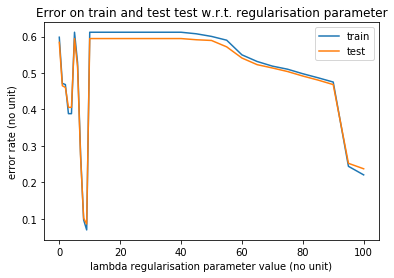

In [12]:
# training and testing errors

lambda_list = [i for i in range(10)] + [i for i in range(10, 101, 5)]

error_dict = {}
for lambda_val in lambda_list:
    model = logistic_regression_newton(l=lambda_val)
    model.fit(Xtrain_log, ytrain)
    ypred_train_lambda = model.predict(Xtrain_log)
    ypred_test_lambda = model.predict(Xtest_log)
    error_train_lambda = len(ypred_train_lambda[ypred_train_lambda != np.squeeze(ytrain)]) /len(ytrain)
    error_test_lambda = len(ypred_test_lambda[ypred_test_lambda != np.squeeze(ytest)]) /len(ytest)
    error_dict[lambda_val] = [error_train_lambda, error_test_lambda]
error_df = pd.DataFrame.from_dict(error_dict).T
error_df.columns = ["train", "test"]

# ploting train and test errors w.r.t the regularisation parameter lambda
error_df.plot()
plt.xlabel("lambda regularisation parameter value (no unit)")
plt.ylabel("error rate (no unit)")
plt.title("Error on train and test test w.r.t. regularisation parameter")
# comments on the graph obtained
print("The training and testing error are quite close to each other."
      " There is an omptimum for both train and test error around lambda=9 to about 10%."
      " This suggests that the right amount of regularisation on the model is around lambda=9 for this dataset.")
# print errors in train and test set at lambda = 1, 10, 100
error_df.loc[[1, 6,7, 8, 9, 10, 100]]

# Q4 K-Nearest Neighboors

In [10]:
class KNN:
    def __init__(self, K=3):
        """
        class for K-nearest neigbors classifier
        binary classifier and can work for multi-class classifier as well
        ...
        Parameters
        ----------
        K: int (default=3)
            number of neighboors
        """
        self.K = K
        self.classes = None
        self.nbclasses = None
        
    def fit_predict(self, Xtrain, ytrain, Xtest): 
        """
        Parameters
        ----------
        Xtrain: numpy nd matrix of 0 or 1 (type float), dim N*D, N=number of samples, D=number of features
            dataset used to train the model 
        ytrain: numpy nd matrix of 0 or 1 (type float), dim N*1, N=number of samples
            label class of each training sample
        Xtest: numpy nd matrix of 0 or 1 (type float), dim n*D, n=number of samples, D=number of features
            dataset with labels to predict
        Returns
        -------
        ypred: numpy nd matrix of 0 or 1 (type float), dim n*1, n=number of samples
            predicted labels for each test sample
        """
        self.classes = np.unique(ytrain)  # get unique classes
        self.nbclasses = len(self.classes) # get number of classes
        D = distance_matrix(Xtest, Xtrain)  # compute distance matrix using Euclidian distance between train and test samples
        # indD gets the index of the K nearest neigboors in the training samples of each test samples 
        if (Xtrain.shape == Xtest.shape) and (Xtrain == Xtest).all(): # if Xtrain = Xtest, predict on train set
            indD = np.concatenate(np.expand_dims([np.argpartition(D[i,:], K+1)[1:K+1] for i in range(D.shape[0])], axis=0), axis=1)
            # for a sample xi, we need to remove itself to its nearest neigboors (since distance(xi, xi) = 0 is minimum)
        else: # if predict on test set
            indD = np.concatenate(np.expand_dims([np.argpartition(D[i,:], K)[:K] for i in range(D.shape[0])], axis=0), axis=1)
        labelD = np.transpose(np.concatenate(np.array([np.array([ytrain[ind] for ind in indrow]) for indrow in indD]), axis=1))
        # get the labels of the K nearest neigboors of each test sample
        preds = np.array([[len(indrow[indrow == c])/K for c in self.classes] for indrow in labelD])
        # compute the frequency of appearance of each class within the K nearest neigboors 
        ypred = np.expand_dims(np.argmax(preds, axis=1), axis=1) # the predicted class is the one with the highest frequency
        return ypred

The testing error follows the training error but is larger. Error is quite low (less than 10%). Both errors are minimal when the number of neigboors is K=5. So, K=5 is the optimal value of this parameter.


,train,test
1,0.065905,0.069010
2,0.061990,0.083984
3,0.051223,0.063151
4,0.048613,0.064453
5,0.046982,0.059245
6,0.052529,0.065104
10,0.054160,0.074219
100,0.094617,0.091797


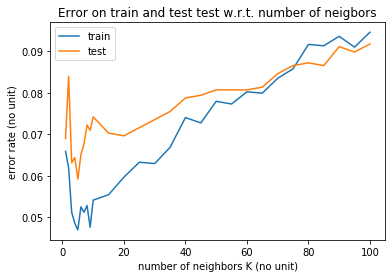

In [11]:
K_list = [i for i in range(1,10)] + [i for i in range(10, 101, 5)]

error_dict = {}
for K in K_list:
    ypred_train_K = KNN(K).fit_predict(Xtrain_log, ytrain, Xtrain_log)
    ypred_test_K = KNN(K).fit_predict(Xtrain_log, ytrain, Xtest_log)
    error_train_K = len(ypred_train_K[ypred_train_K != ytrain]) / len(ytrain)
    error_test_K = len(ypred_test_K[ypred_test_K != ytest]) / len(ytest)
    error_dict[K] = [error_train_K, error_test_K]
error_df = pd.DataFrame.from_dict(error_dict).T
error_df.columns = ["train", "test"]

# ploting train and test errors w.r.t alpha
error_df.plot()
plt.xlabel("number of neighbors K (no unit)")
plt.ylabel("error rate (no unit)")
plt.title("Error on train and test test w.r.t. number of neigbors")
# comments on the graph obtained
print("The testing error follows the training error but is larger. Error is quite low (less than 10%)."
      " Both errors are minimal when the number of neigboors is K=5."
      " So, K=5 is the optimal value of this parameter.")
# print errors in train and test set at K = 1, 10, 100
error_df.loc[[1, 2, 3, 4, 5, 6, 10, 100]]

# Q5 Survey

I spent about 20 hours to complete this assignement.

It was the first time I was asked to code classifiers from scratch even though I already studied machine learning and deep learning classes. So, I thought this was useful. 

I appreciated that this assignement is an implementation of what has been studied in class. It helps getting a full and deep understanding of the lecture materials.